# Explore Dataset
1. Temporal Patterns
2. Spatial Patterns

# 0. Setup

In [43]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import geohash

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = './input/'
data = pd.read_csv(path+'training.csv')
print('N:', len(data))
print('TAZ:', len(data['geohash6'].unique()))
data.head()

N: 4206321
TAZ: 1329


,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


# 1. Temporal Patterns
# TODO
- stationarity / with 1 diff, with seasonal diff: rolling mean and std
- daily trend
- hourly trend / by day of week

In [3]:
from rdforecast import datasets
data = datasets.convert_datetime(data)

In [4]:
data.head()

,geohash6,day,timestamp,demand,date,time,datetime
0,qp03wc,18,20:0,0.020072,2018-01-19,20:00:00,2018-01-19 20:00:00
1,qp03pn,10,14:30,0.024721,2018-01-11,14:30:00,2018-01-11 14:30:00
2,qp09sw,9,6:15,0.102821,2018-01-10,06:15:00,2018-01-10 06:15:00
3,qp0991,32,5:0,0.088755,2018-02-02,05:00:00,2018-02-02 05:00:00
4,qp090q,15,4:0,0.074468,2018-01-16,04:00:00,2018-01-16 04:00:00


In [5]:
counts = data['geohash6'].value_counts()
counts = dict(zip(counts.index, counts.values))
max_count = 61 * 24 * 4

In [24]:
data['dow'] = data['day'] % 7

In [25]:
dow = data.groupby(['dow', 'time']).mean()[['demand']]
dow = dow.reset_index()

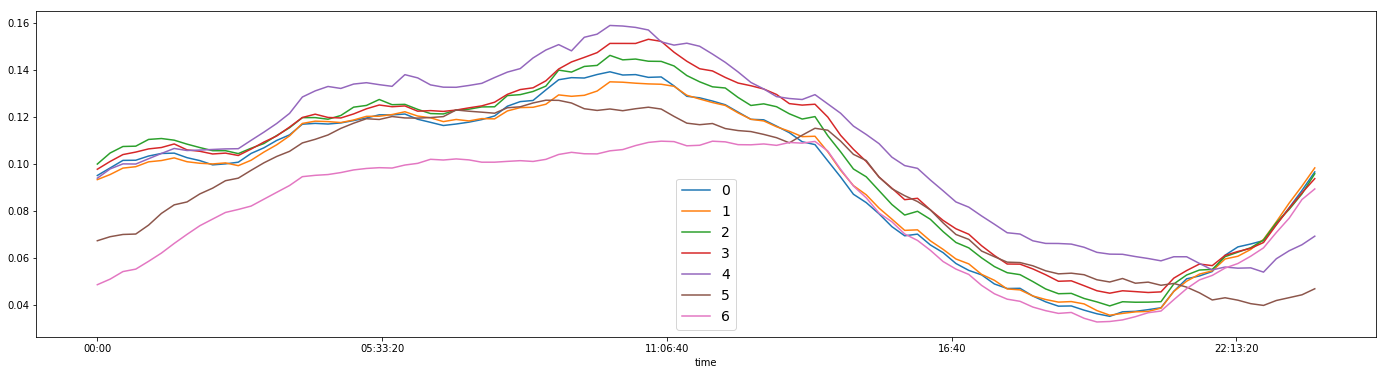

In [26]:
fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
for i in range(7):
    tmp = dow[dow['dow'] == i]
    ax.plot(tmp['time'], tmp['demand'], label=i)
plt.legend(fontsize=14)

In [19]:
# counts = data['geohash6'].value_counts()
# counts = dict(zip(counts.index, counts.values))
# max_count = 61 * 24 * 4
# dow = data.groupby(['dow', 'time']).mean()[['demand']]
# dow = dow.reset_index()
# data.groupby('dow').count()['geohash6']
# data.groupby('dow').sum()['demand']

## 1.1 Daily demands per TAZ

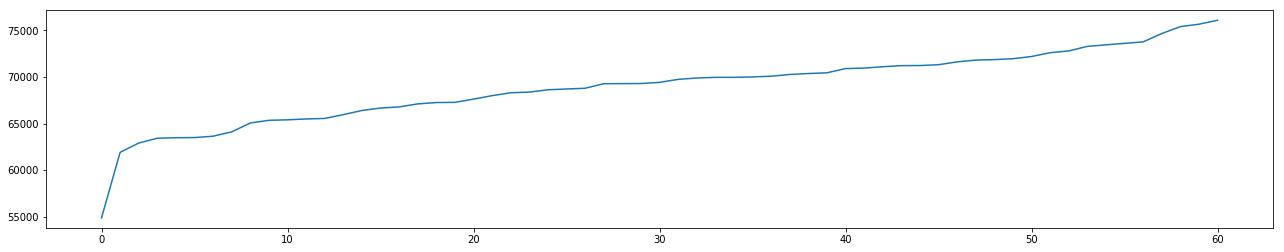

In [50]:
n_active_taz = np.sort(data['day'].value_counts())
plt.figure(figsize=(22,4))
plt.plot(n_active_taz)
plt.show()

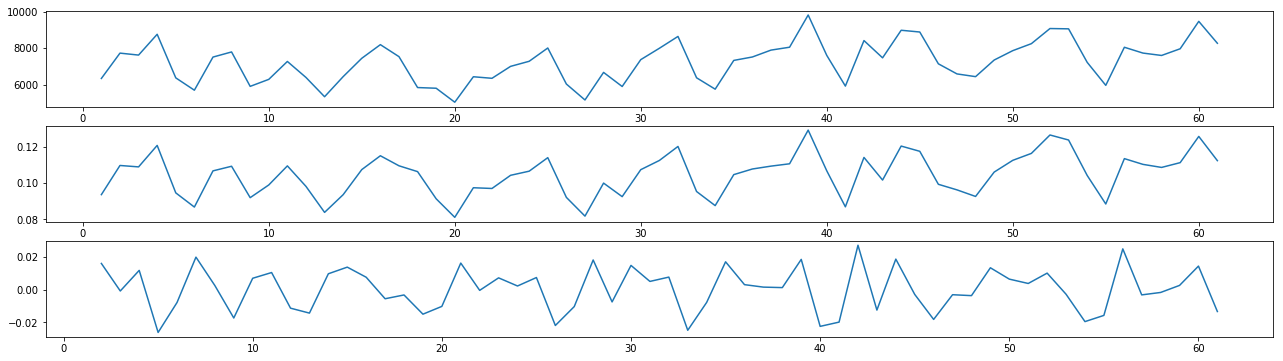

In [51]:
daily_demand_mean = data.groupby('day').mean()['demand']
daily_demand_sum = data.groupby('day').sum()['demand']
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(daily_demand_sum)
ax2.plot(daily_demand_mean)
ax3.plot(daily_demand_mean.diff())
plt.show()

In [29]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [52]:
# X = daily_demand_mean.values
taz_demand = data['geohash6'].value_counts()
sample = taz_demand.index[0]
sample = data[data['geohash6'] == sample].sort_values(['datetime'])
X = sample['demand'].values

## Stationary Test
- H0: time series is non-stationary 

In [61]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.568324
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [63]:
result = adfuller(np.diff(X))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.425611
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Autocorrelation Test

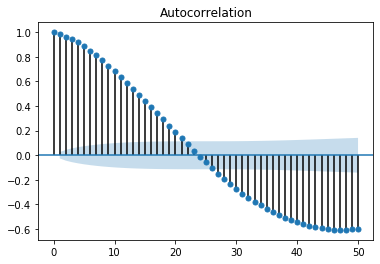

In [97]:
plot_acf(X, lags=50);

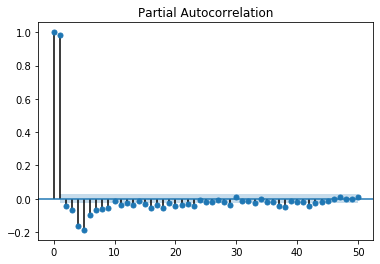

In [98]:
plot_pacf(X, lags=50);

In [28]:
from statsmodels.tsa.arima_model import ARIMA

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5846
Model:                     ARMA(1, 0)   Log Likelihood                8420.541
Method:                       css-mle   S.D. of innovations              0.057
Date:                Thu, 06 Jun 2019   AIC                         -16835.081
Time:                        20:08:43   BIC                         -16815.061
Sample:                             0   HQIC                        -16828.120
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6862      0.044     15.502      0.000       0.599       0.773
ar.L1.y        0.9832      0.002    411.293      0.000       0.979       0.988
                                    Roots           

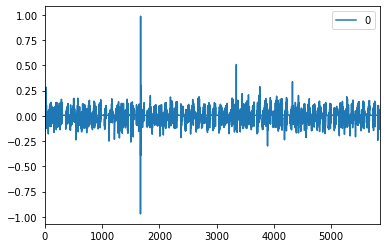

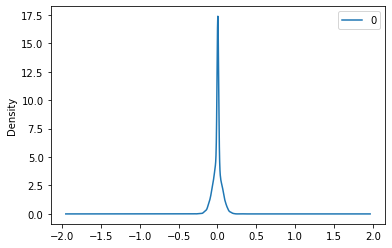

                 0
count  5846.000000
mean      0.000074
std       0.057576
min      -0.971716
25%      -0.021918
50%       0.005263
75%       0.016098
max       0.985548


In [100]:
model = ARIMA(X, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

predicted=0.994613, expected=1.000000
predicted=0.994615, expected=1.000000
predicted=0.994617, expected=1.000000
predicted=0.994618, expected=1.000000
predicted=0.994620, expected=1.000000
predicted=0.994622, expected=1.000000
predicted=0.994624, expected=1.000000
predicted=0.994626, expected=1.000000
predicted=0.994627, expected=1.000000
predicted=0.994629, expected=1.000000
predicted=0.994631, expected=1.000000
predicted=0.994633, expected=1.000000
predicted=0.994634, expected=1.000000
predicted=0.994636, expected=1.000000
predicted=0.994638, expected=1.000000
predicted=0.994640, expected=1.000000
predicted=0.994642, expected=1.000000
predicted=0.994643, expected=1.000000
predicted=0.994645, expected=1.000000
predicted=0.994647, expected=1.000000
predicted=0.994649, expected=1.000000
predicted=0.994651, expected=1.000000
predicted=0.994652, expected=1.000000
predicted=0.994654, expected=1.000000
predicted=0.994656, expected=1.000000
predicted=0.994658, expected=0.751382
predicted=0.

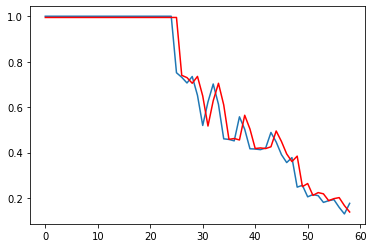

In [102]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

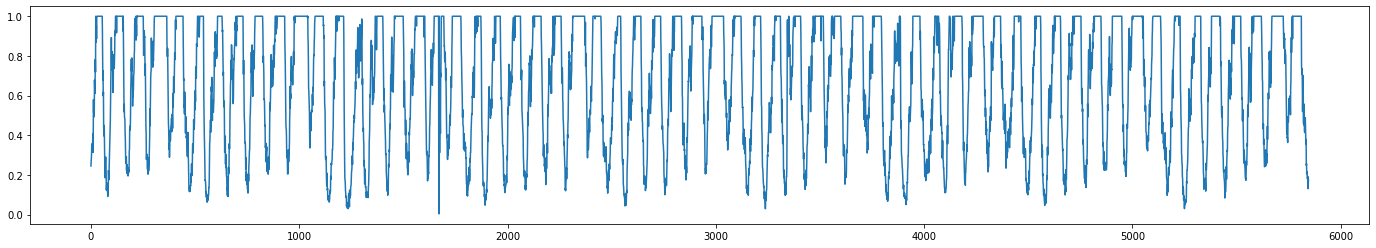

In [94]:
plt.figure(figsize=(24,4))
plt.plot(range(len(sample)), sample['demand'])

In [86]:
y_pred = model_fit.predict(len(train), len(train)+len(test))

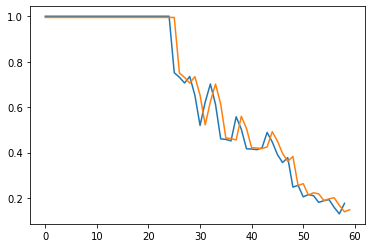

In [87]:
plt.plot(test)
plt.plot(y_pred)

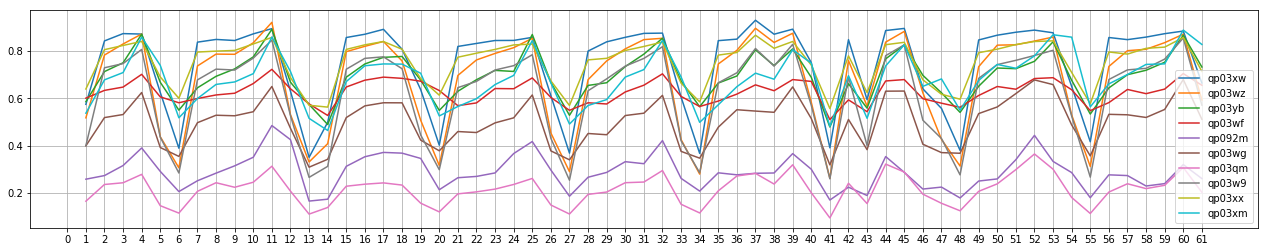

In [160]:
taz_demand = data['geohash6'].value_counts()
samples = taz_demand.index[:10]

plt.figure(figsize=(22,4))
for sample in samples:
    sample_taz = data[data['geohash6'] == sample]
    daily_demand = sample_taz.groupby(['day']).mean()
    plt.plot(daily_demand['demand'], label=sample)
plt.xticks(range(62))
plt.legend()
plt.grid()

In [54]:
taz_daily = data.groupby(['geohash6', 'day'])['demand'].sum().reset_index()
taz_daily = taz_daily.pivot(index='geohash6', columns='day', values='demand')
taz_daily.fillna(0, inplace=True)
assert sum(taz_daily.sum(axis=1) == 0) == 0

# standardize
tazmean = taz_daily.mean(axis=1)
tazstd = taz_daily.std(axis=1)
taz_daily = taz_daily.apply(lambda x: (x - tazmean) / tazstd)
taz_daily['active_count'] = taz_daily.index.map(counts) / max_count
taz_daily.head()

day,1,2,3,4,5,6,7,8,9,10,...,53,54,55,56,57,58,59,60,61,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,-0.810720,-0.553245,-0.502718,0.408039,-0.802496,-1.007065,0.352295,-0.445095,0.938419,-0.544423,...,1.866856,-0.589964,-0.958830,0.397738,0.461034,-0.491166,4.514224,2.272901,0.909376,0.098531
qp02yf,-0.421247,-0.136156,0.290865,-0.245631,-0.329872,-0.001902,0.248657,-0.421247,-0.234069,-0.115328,...,-0.421247,-0.396947,-0.421247,0.525120,-0.421247,-0.402783,0.021777,0.060569,-0.171389,0.015198
qp02yu,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,-0.135846,...,-0.135846,0.347395,-0.135846,-0.135846,-0.135846,-0.135846,7.667498,-0.135846,-0.135846,0.000342
qp02yv,-0.197097,-0.197097,-0.197097,-0.197097,0.284647,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,...,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,-0.197097,0.001195
qp02yy,-0.128547,0.389281,-0.249925,0.554634,-0.328009,0.121216,-0.333908,-0.340643,0.595424,-0.408952,...,-0.408952,0.111999,-0.351073,0.091913,-0.274491,-0.396727,-0.408952,0.223138,0.130987,0.018101


In [55]:
taz_quarterly = data.groupby(['geohash6', 'timestamp'])['demand'].mean().reset_index()

ts = taz_quarterly['timestamp'].unique()
h, m = zip(*[t.split(':') for t in ts])
h = np.array([int(i) for i in h])
m = np.array([(int(i) / 60) for i in m])
ts_num = h + m
ts_to_num = dict(zip(ts, ts_num))

taz_quarterly['timestamp'] = taz_quarterly['timestamp'].map(ts_to_num)
taz_quarterly = taz_quarterly.pivot(index='geohash6', columns='timestamp', values='demand')
taz_quarterly.fillna(0, inplace=True)
assert sum(taz_quarterly.sum(axis=1) == 0) == 0

# standardize
tazmean = taz_quarterly.mean(axis=1)
tazstd = taz_quarterly.std(axis=1)
taz_quarterly = taz_quarterly.apply(lambda x: (x - tazmean) / tazstd)
taz_quarterly['active_count'] = taz_quarterly.index.map(counts) / max_count
taz_quarterly.head()

timestamp,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,0.817159,0.050268,-1.099626,-0.366929,0.393077,1.279391,-0.359270,-0.092664,1.007797,1.120308,...,-1.099626,-1.099626,-0.755862,-0.469505,0.511916,-0.082454,0.710992,-0.599751,-0.005873,0.098531
qp02yf,-0.085207,-0.592257,-0.592257,0.491229,2.053358,-0.512706,0.725651,-0.592257,-0.592257,0.018750,...,-0.592257,-0.592257,-0.592257,-0.592257,-0.592257,-0.592257,-0.592257,1.723108,-0.000469,0.015198
qp02yu,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,...,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,-0.108246,0.000342
qp02yv,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,...,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,-0.207141,0.001195
qp02yy,0.184683,3.063896,4.494958,0.729941,-0.068113,0.285598,0.558304,-0.246825,0.212538,-0.531758,...,-0.531758,-0.531758,-0.531758,-0.531758,1.336675,0.953458,-0.531758,-0.531758,-0.531758,0.018101


In [47]:
from sklearn.cluster import KMeans

# define a function that does K-means clustering and plot the results
def plotKM(df, n_timesteps, n_features, n_clusters, random_state=2019):
    """
    Arg:
        1. df: df to cluster (as dataframe)
        2. n_clusters: number of clusters
        3. random: seed number for random_state
    Return:
        1. append labels back to df as label_km'n'
        2. plot cluster result
    """
    print('Last feature:', df.columns[n_features - 1])
    
    # run K-means and assign results
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    res = km.fit(df.iloc[:, :n_features])
    df['label_km{}'.format(n_clusters)] = res.labels_
    
    # plot results
    plt.figure(figsize=(16,10))

    for l in range(n_clusters):
        # subset df and calculate means for each label
        df_ = df[df['label_km{}'.format(n_clusters)] == l]
        df_means = df_.mean(axis=0)
        
        plt.subplot(np.ceil(n_clusters/2), 2, 1+l)
        for i in range(len(df_)):
            plt.plot(range(n_timesteps), df_.iloc[i, :n_timesteps], 'steelblue', alpha=0.2)
            plt.plot(range(n_timesteps), df_means[:n_timesteps], 'indianred', linewidth=2)
        plt.xticks(np.arange(0, n_timesteps, 4), rotation=45)
        plt.title('KM Cluster Label: {} (n = {})'.format(l, len(df_)))

    plt.tight_layout()
    plt.show()

In [25]:
from sklearn.metrics import silhouette_score

# Choose a range of cluster numbers that you would like to evalulate:
range_n_clusters = range(2,20)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=i)
    res = km.fit(X)  
    silhouette_avg = silhouette_score(X, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.04476054774904301
For n_clusters = 3, the average silhouette_score is : 0.055529571140124113
For n_clusters = 4, the average silhouette_score is : 0.04461733906263725
For n_clusters = 5, the average silhouette_score is : 0.04018652103344094
For n_clusters = 6, the average silhouette_score is : 0.059582967572974016
For n_clusters = 7, the average silhouette_score is : 0.05995839617383974
For n_clusters = 8, the average silhouette_score is : 0.05163359820331312
For n_clusters = 9, the average silhouette_score is : 0.056334506535402576
For n_clusters = 10, the average silhouette_score is : 0.052957255222030576
For n_clusters = 11, the average silhouette_score is : 0.03922782824509469
For n_clusters = 12, the average silhouette_score is : 0.04276543827846382
For n_clusters = 13, the average silhouette_score is : 0.03729706916288532
For n_clusters = 14, the average silhouette_score is : 0.04971175466656652
For n_clusters = 15, the aver

[51019.79408137762, 45410.13220388776, 42174.1347336804, 39571.8928408517, 37725.26673409277, 36722.53122162813, 35840.848190472585, 34992.774065049, 34405.886215673265, 33990.34119642306, 33569.18294071536, 33272.756240848845, 32946.64196959111, 32681.545023858554, 32373.52677057236, 32005.47476587116, 31676.106380563404, 31400.591133622504]


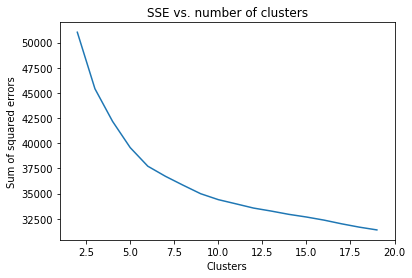

In [19]:
X = taz_daily.iloc[:, :61]
SSE = []
for i in range(2,20):
    km = KMeans(n_clusters=i)
    res = km.fit(X)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,20), SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1,20)
plt.show()

In [22]:
res.inertia_?

Type:            float64
String form:     29692.613148840734
File:            ~/anaconda/lib/python3.6/site-packages/numpy/__init__.py
Docstring:       <no docstring>
Class docstring: 64-bit floating-point number. Character code 'd'. Python float compatible.


[42665.865006310036, 38633.36126454458, 36448.775659036866, 35251.97973382393, 34407.65795714129, 33716.581652056666, 33114.02105770861, 32689.109587457056, 32210.033164983462, 31852.024402439354, 31499.99372297271, 31317.8302897127, 31018.901662287473, 30748.878109901696, 30433.48588289236, 30274.509137673365, 30155.135816876566, 29692.613148840734]


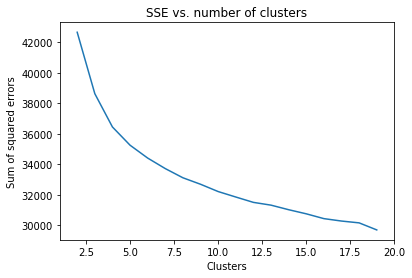

In [21]:
X = taz_quarterly.iloc[:, :96]
SSE = []
for i in range(2,20):
    km = KMeans(n_clusters=i)
    res = km.fit(X)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,20), SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1,20)
plt.show()

Last feature: active_count


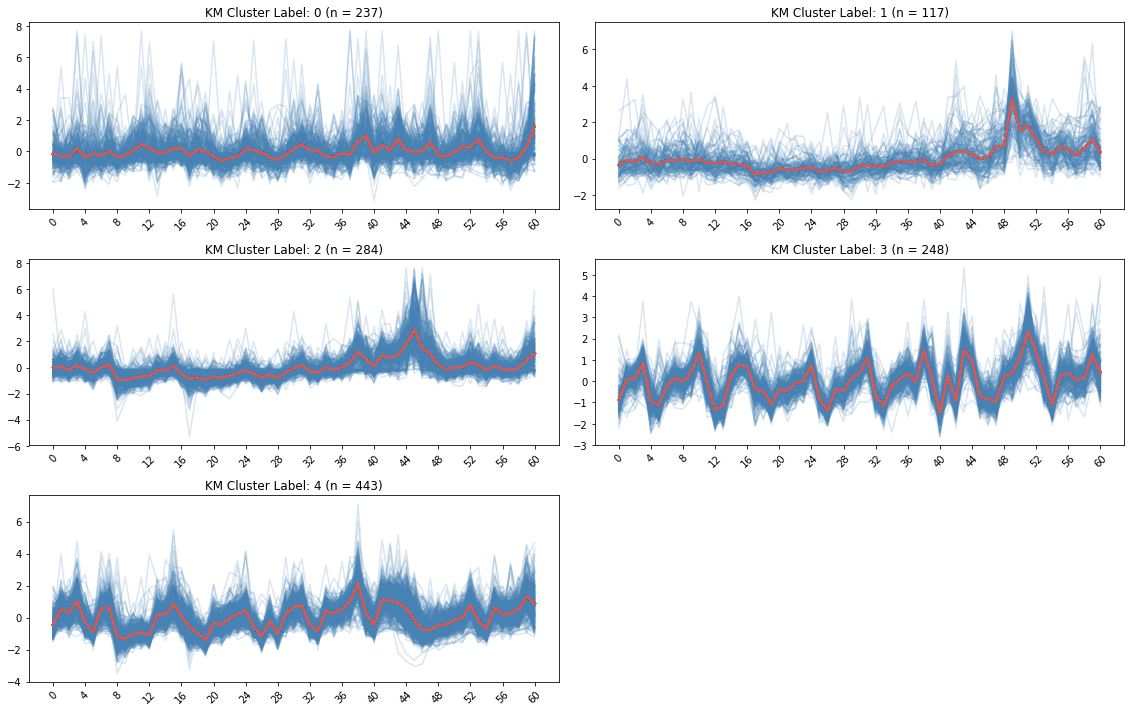

Last feature: active_count


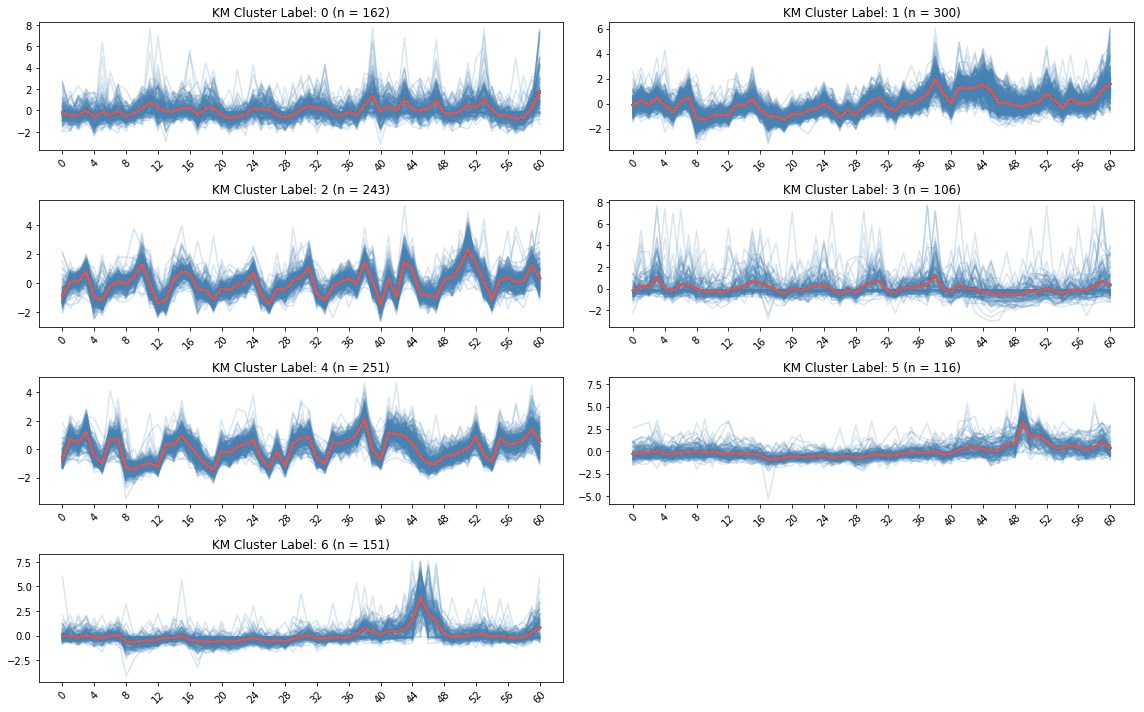

Last feature: active_count


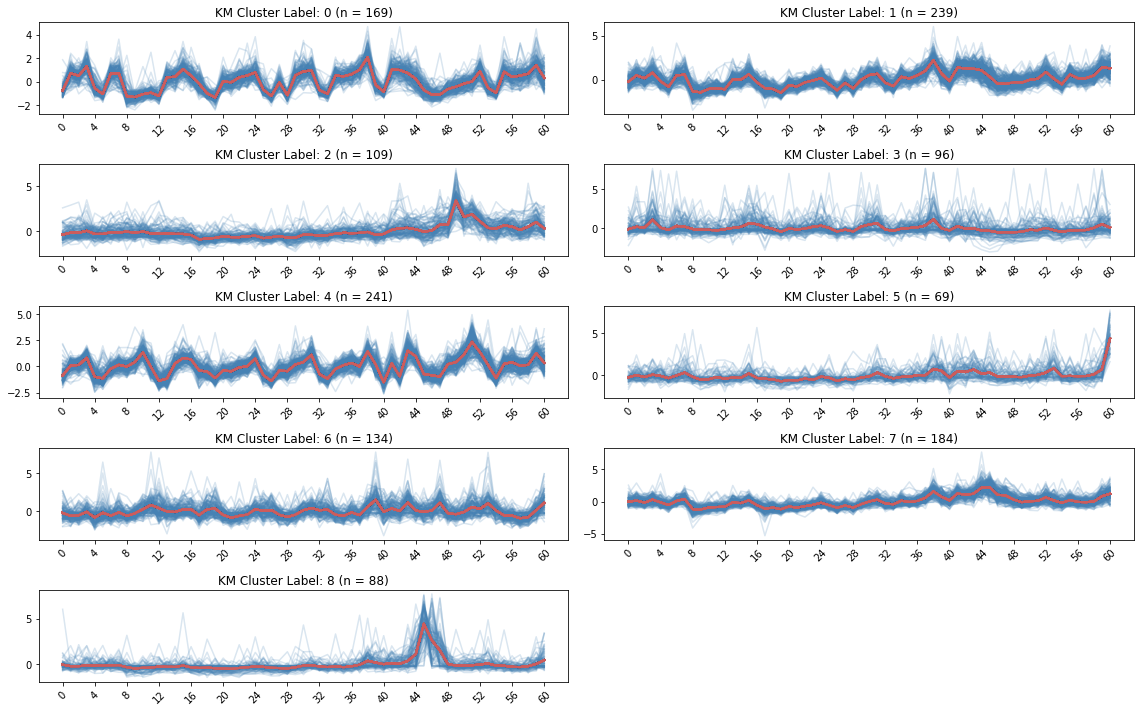

In [56]:
n_timesteps = 61
n_features = 62
plotKM(taz_daily, n_timesteps, n_features, 5)
plotKM(taz_daily, n_timesteps, n_features, 7)
plotKM(taz_daily, n_timesteps, n_features, 9)

In [58]:
x, y = zip(*[(latlon[1], latlon[0]) for latlon in taz_daily.index.map(geohash.decode)])

/home/yuwen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


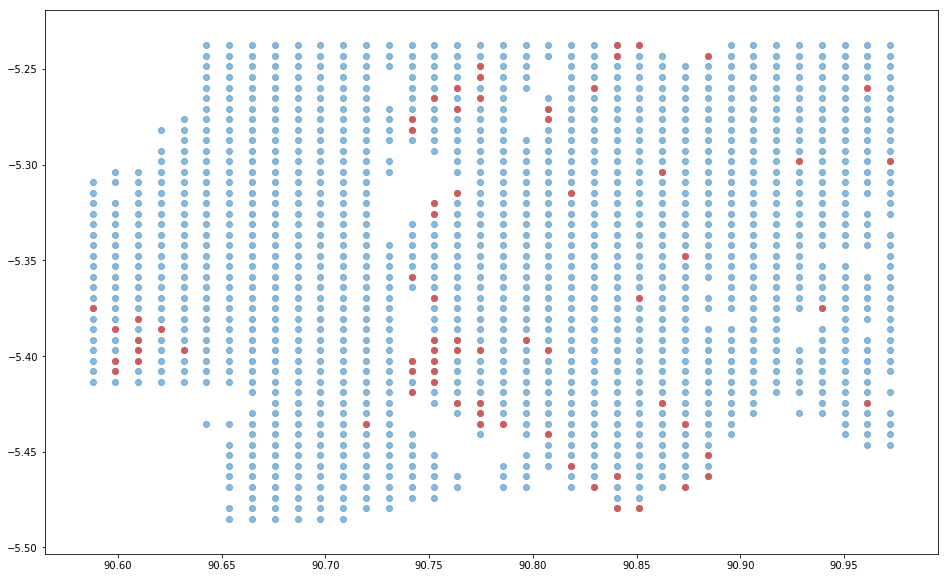

In [59]:
weird = taz_daily[taz_daily['label_km9'] == 5]
weird['x'], weird['y'] = zip(*[(latlon[1], latlon[0]) for latlon in weird.index.map(geohash.decode)])
plt.figure(figsize=(16,10))
plt.scatter(x, y, alpha=0.5)
plt.scatter(weird['x'], weird['y'], c='indianred')

In [ ]:
n_timesteps = 96
n_features = 97
plotKM(taz_quarterly, n_timesteps, n_features, 5)
plotKM(taz_quarterly, n_timesteps, n_features, 7)
plotKM(taz_quarterly, n_timesteps, n_features, 9)

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


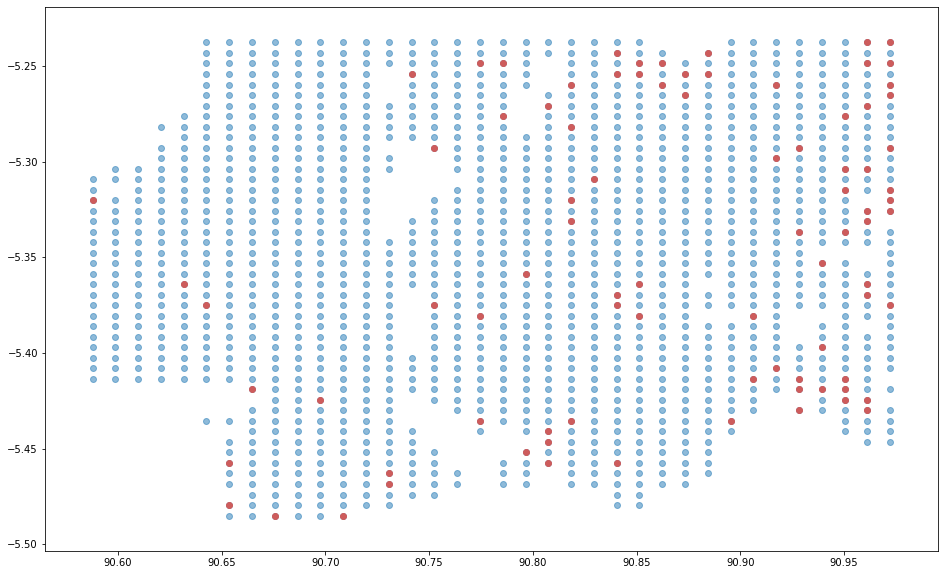

In [123]:
weird = taz_quarterly[taz_quarterly['label_km9'] == 8]
weird['x'], weird['y'] = zip(*[(latlon[1], latlon[0]) for latlon in weird.index.map(geohash.decode)])
plt.figure(figsize=(16,10))
plt.scatter(x, y, alpha=0.5)
plt.scatter(weird['x'], weird['y'], c='indianred')

# cluster regions
# cluster time series
- those that remain constant throughout the week
- those that has different am/pm demands

# 2. Spatial Patterns

In [52]:
import geohash
data['x'], data['y'] = zip(*[(latlon[1], latlon[0]) for latlon in data['geohash6'].map(geohash.decode)])

In [154]:
gdf_taz = gdf[['geohash6', 'geometry']].drop_duplicates(subset=['geohash6'], keep='first')
assert len(gdf_taz) == 1329
gdf_taz = gdf_taz.merge(taz_daily.reset_index()[['geohash6', 'label_km5', 'label_km7', 'label_km9']], how='left', on='geohash6')
gdf_taz['lon'] = gdf_taz['geometry'].apply(lambda p: (p.x))
gdf_taz['lat'] = gdf_taz['geometry'].apply(lambda p: (p.y))
gdf_taz.head(1)

,geohash6,geometry,label_km5,label_km7,label_km9,lon,lat
0,qp03wc,POINT (90.6536865234375 -5.35308837890625),2,2,1,90.653687,-5.353088


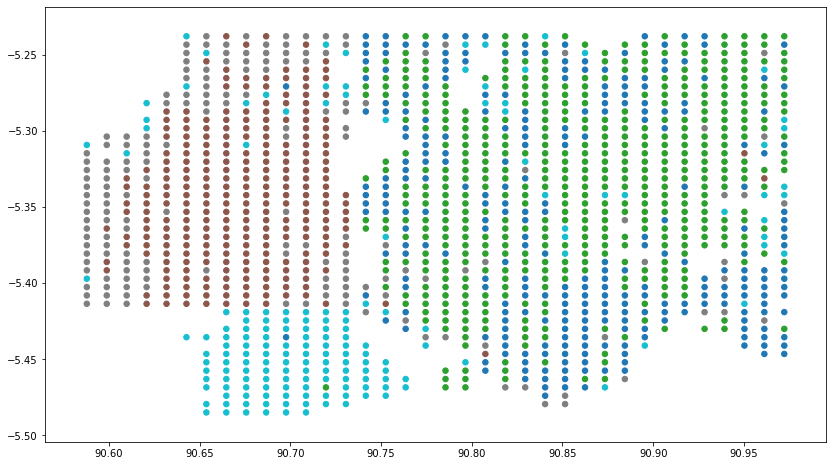

In [149]:
plt.figure(figsize=(14, 8))
plt.scatter(gdf_taz['lon'], gdf_taz['lat'], c=gdf_taz['label_km5'], cmap='tab10', alpha=1, s=30)

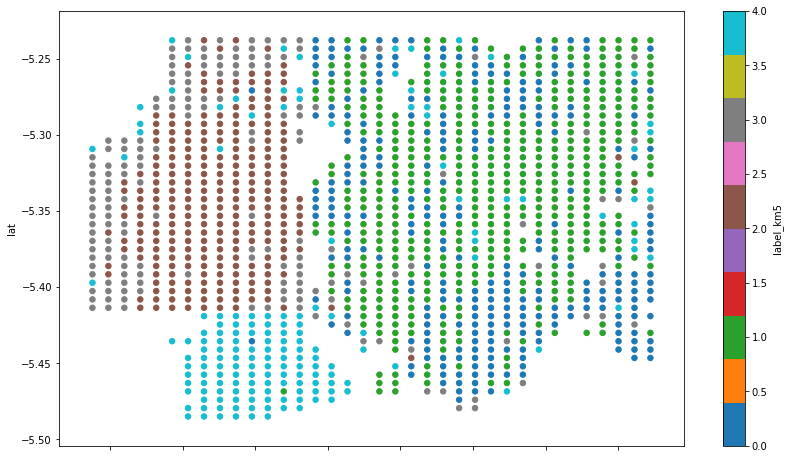

In [159]:
pd.DataFrame(gdf_taz).plot.scatter('lon', 'lat', c='label_km5', cmap='tab10', alpha=1, s=30, figsize=(14, 8))

In [ ]:
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib

carat = [5, 10, 20, 30, 5, 10, 20, 30, 5, 10, 20, 30]
price = [100, 100, 200, 200, 300, 300, 400, 400, 500, 500, 600, 600]
color =['D', 'D', 'D', 'E', 'E', 'E', 'F', 'F', 'F', 'G', 'G', 'G',]
df = pd.DataFrame(dict(carat=carat, price=price, color=color))

fig, ax = plt.subplots()
colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}
ax.scatter(df['carat'], df['price'], c=df['color'].apply(lambda x: colors[x]))
plt.show()

import seaborn as sns
sns.lmplot('carat', 'price', data=df, hue='color', fit_reg=False)
plt.show()

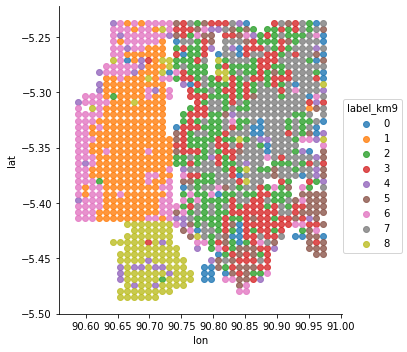

In [146]:
import seaborn as sns
sns.lmplot('lon', 'lat', data=gdf_taz, hue='label_km9', fit_reg=False)
plt.show()

In [ ]:
# dealing with rare demanding areas
unstable = taz_quarterly[taz_quarterly['label_km9'] == 2]
unstable_len = [len(data[data['geohash6'] == g]) for g in unstable.index]
unstable_len

# XGBoost

In [63]:
X = data.merge(taz_quarterly[['label_km9']], how='left', left_on='geohash6', right_index=True)
X = X.merge(taz_daily[['label_km9']], how='left', left_on='geohash6', right_index=True)

In [67]:
X['lon'], X['lat'] = zip(*[(latlon[1], latlon[0]) for latlon in X['geohash6'].map(geohash.decode)])
X['hour'] = X['time'].apply(lambda x: x.hour)
X['timestep'] = X['time'].apply(lambda x: (x.hour * 60 + x.minute) / 15 + 1) + (X['day'] - 1) * 96
X = X[['day', 'hour', 'timestep', 'dow', 'label_km9_x', 'label_km9_y', 'lon', 'lat', 'demand']]

In [146]:
X.head()

,day,hour,timestep,dow,label_km9_x,label_km9_y,lon,lat,demand
0,18,20,1713.0,4,3,4,90.653687,-5.353088,0.020072
1,10,14,923.0,3,7,4,90.664673,-5.413513,0.024721
2,9,6,794.0,2,3,1,90.906372,-5.325623,0.102821
3,32,5,2997.0,4,1,7,90.752563,-5.353088,0.088755
4,15,4,1361.0,1,7,4,90.719604,-5.413513,0.074468


In [69]:
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# scaler = MinMaxScaler()
# scaler.fit_transform(X[['lon', 'lat']])

In [95]:
X_train = X[X['day'] <= 47]
X_test = X[X['day'] > 47]
y_train = X_train.pop('demand')
y_test = X_test.pop('demand')

In [100]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3213492, 8)
(992829, 8)
(3213492,)
(992829,)


In [154]:
model_spec = dict(max_depth=10,
                learning_rate=0.1,
                n_estimators=1000,
                silent=True, objective='reg:squarederror',
                booster='gbtree',
                n_jobs=-1,
                gamma=0,
                min_child_weight=1,
                max_delta_step=0,
                subsample=1,
                colsample_bytree=1,
                colsample_bylevel=1,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                base_score=0.5,
                random_state=0,
                eval_metric='rmse')

In [155]:
import xgboost
best_xgb_model = xgboost.XGBRegressor(**model_spec)
best_xgb_model.fit(X_train, y_train, eval_metric='rmse')

/home/yuwen/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yuwen/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='rmse', gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=1)

In [149]:
def eval_RMSE(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    assert len(y_true) == len(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(rmse)

In [156]:
# train
y_pred = best_xgb_model.predict(X_train)
eval_RMSE(y_train, y_pred)
# test
y_pred = best_xgb_model.predict(X_test)
eval_RMSE(y_test, y_pred)

0.03183241932201408
0.08018216420847601


In [152]:
# train
y_pred = best_xgb_model.predict(X_train)
eval_RMSE(y_train, y_pred)
# test
y_pred = best_xgb_model.predict(X_test)
eval_RMSE(y_test, y_pred)

0.12162863565666235
0.13138516460122748


In [157]:
result = pd.concat([X_test.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]
print(result.shape)
result.head()

(992829, 11)


,day,hour,timestep,dow,label_km9_x,label_km9_y,lon,lat,y_test,y_pred,geohash6
0,51,20,4884.0,2,7,4,90.631714,-5.408020,0.000293,0.004012,qp03nr
1,48,6,4538.0,6,4,7,90.763550,-5.364075,0.054170,0.073783,qp093r
2,52,11,4944.0,3,7,4,90.664673,-5.364075,0.359406,0.151729,qp03rp
3,48,11,4559.0,6,1,5,90.609741,-5.391541,0.057255,0.037799,qp03mf
4,56,10,5321.0,0,1,1,90.774536,-5.413513,0.008772,0.025520,qp091w


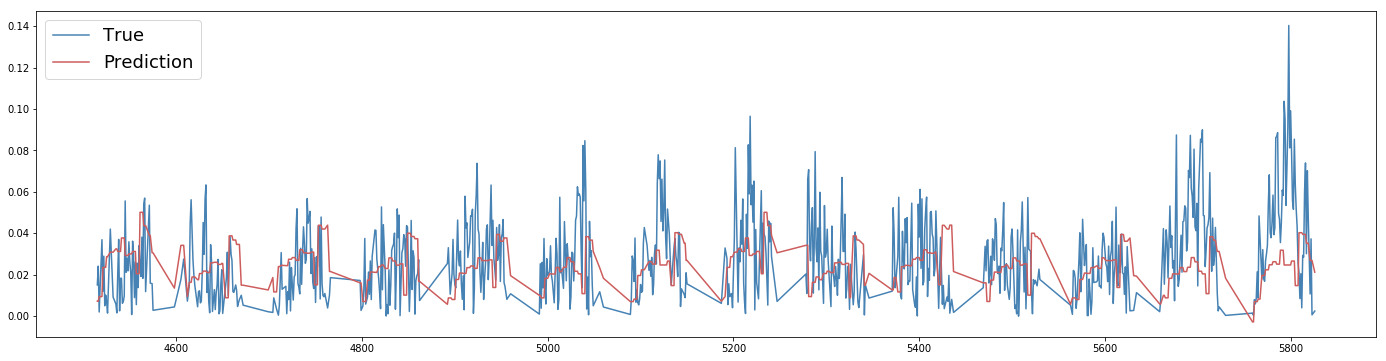

In [158]:
gh = 'qp091w'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

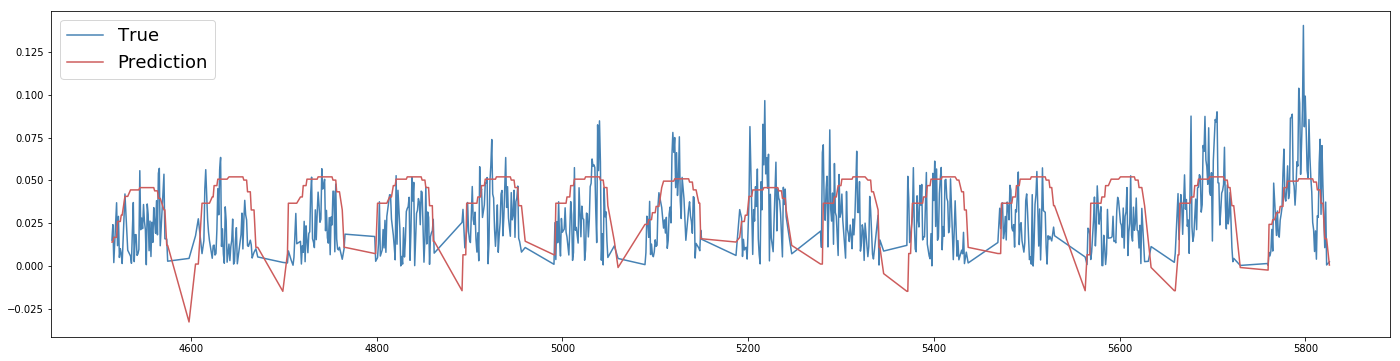

In [148]:
gh = 'qp091w'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

In [196]:
data.to_csv('data_processed.csv', index=None)

In [200]:
output = data.sample(100000)
output.to_csv('output.csv', index=None)

# 9. Notes

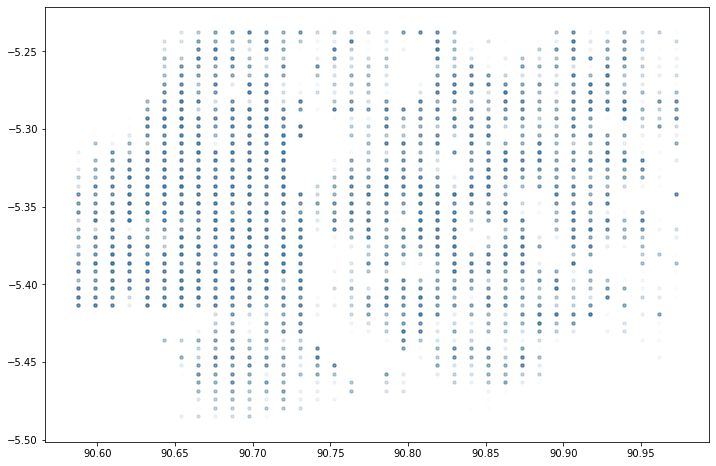

In [58]:
# TODO: slow
from shapely.geometry import Point
geom = [Point(latlon[1], latlon[0]) for latlon in data['geohash6'].apply(geohash.decode)]
gdf = gpd.GeoDataFrame(data, geometry=geom)
gdf.sample(50000).plot(figsize=(14, 8), alpha=0.01, markersize=10)

In [326]:
%%timeit
x, y = zip(*[(latlon[1], latlon[0]) for latlon in data['geohash6'][:1000].map(geohash.decode)])

2.26 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [327]:
%%timeit
geom = [Point(latlon[1], latlon[0]) for latlon in data['geohash6'][:1000].apply(geohash.decode)]

17.4 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
tmp = pd.to_datetime(data['time'][:10000].astype(str) + ' ' + data['date'][:10000].astype(str))

1.36 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
tmp = data[:10000].apply(lambda x: pd.datetime.combine(x['date'], x['time']), 1)

430 ms ± 70.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
